In [1]:
import pynbody
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.modeling import models, fitting
from photutils import isophote, aperture_photometry
from photutils import CircularAperture, EllipticalAperture, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse
import ipywidgets
from luminosity import surface_brightness, color_plot, kpc2pix

In [2]:
def bounding_box(snap):
    unit = snap['pos'].units
    for coord in 'x y z'.split():
        print("{}: {:10.2f}, {:10.2f} ({})".format(coord, snap[coord].min(), snap[coord].max(), unit))
    return [(float(snap[coord].min()), float(snap[coord].max())) for coord in 'x y z'.split()]

In [3]:
def to_astropy_quantity(simarr, units=None):
    return u.Quantity(simarr.view(type=np.ndarray), unit=units if units is not None else str(simarr.units))

In [4]:
def ss_angmom(flux, r, v_los, v_disp):
    return np.sum(flux * r * np.abs(v_los)) / np.sum(flux * r * np.sqrt(v_los**2 + v_disp**2))
def compute_stellar_specific_angmom(snap, width, resolution, radii, eccentricity, a_delta, theta):
    luminosity_sim = surface_brightness(snap.s, band='v', width=width, resolution=resolution, mag_filter=None, cmap_name='Greys')
    v_los_sim = pynbody.plot.sph.image(snap.s, qty='vz', av_z='rho', width=width, resolution=resolution, log=False)
    v_disp_sim = pynbody.plot.sph.image(snap.s, qty='v_disp', av_z='rho', width=width, resolution=resolution, log=False)
    lum = to_astropy_quantity(luminosity_sim, units='mag/arcsec**2')
    v_los = to_astropy_quantity(v_los_sim)
    v_disp = to_astropy_quantity(v_disp_sim)
    lum_annuli = integrate_annulus(lum, center, radii, eccentricity, a_delta, theta)
    v_los_annuli = integrate_annulus(v_los, center, radii, eccentricity, a_delta, theta)
    v_disp_annuli = integrate_annulus(v_disp, center, radii, eccentricity, a_delta, theta)
    stellar_specific_angmom = ss_angmom(lum_annuli, radii, v_los_annuli, v_disp_annuli)
    return stellar_specific_angmom

In [5]:
def fit_sersic(img, r_eff, n, ellip, theta):
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=res_x/2, y_0=res_y/2, ellip=ellip, theta=theta,
                         fixed={'amplitude':False, 'n':False, 'ellip':False, 'x_0':True, 'y_0':True},
                         bounds={})#'theta':(0, np.pi)})
    fit_s = fitting.SLSQPLSQFitter()
    # notnans = np.isfinite(img)
    # sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
    sersic = fit_s(s_init, x, y, img)
    return sersic

In [6]:
def plot_fit(img, fit):
    # Plot the data with the best-fit model
    res_x, res_y = img.shape
    y, x = np.mgrid[:res_x, :res_y]
    plt.figure(figsize=(12,2.5))
    plt.subplot(1,3,1)
    data = plt.imshow(img, origin='lower', interpolation='nearest')
    plt.title("Data")
    plt.colorbar(data)
    plt.subplot(1,3,2)
    mod = plt.imshow(fit(x, y), origin='lower', interpolation='nearest')
    plt.colorbar(mod)
    plt.title("Model")
    plt.subplot(1,3,3)
    residual = img - fit(x, y)
    res = plt.imshow(residual, origin='lower', interpolation='nearest')
    plt.colorbar(res)
    plt.title("Residual");
    print("residual: ({:.4f}, {:.4f})".format(residual.min(), residual.max()))

In [7]:
def plot_angmom(snap, ax):
    """Plot the projected angular momentum on the map on `ax`, after having
    normalized it to one. It means that short arrows plotted means L almost
    aligned with line-of-sight-direction."""
    L = pynbody.analysis.angmom.ang_mom_vec(snap)
    print("L:", L)
    norm = np.linalg.norm(L)
    ax.arrow(0, 0, L[0]/norm, L[1]/norm, head_width=0.2, head_length=.2, color='red');

In [8]:
snap = "/home/michele/sim/MoRIA/M1-10_Verbeke2017/M10sim41001/snapshot_0036"
s = pynbody.load(snap)

In [9]:
max_boxsize = 4000

In [10]:
s.properties['boxsize'] = pynbody.units.Unit("{} kpc".format(max_boxsize))

In [11]:
s.properties

{'time': Unit("1.34e+01 s kpc km**-1"), 'boxsize': Unit("4.00e+03 kpc")}

In [12]:
width = 5
resolution = 500

In [13]:
pynbody.analysis.halo.center(s.g)#, vel=False)
subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-width*1.1))]

Plot density

L: [0.03284372 0.10882048 0.5501113 ]


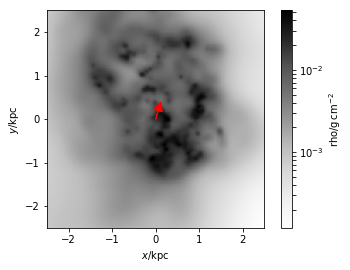

In [15]:
fig, ax = plt.subplots()
pynbody.analysis.angmom.faceon(subsnap.s)
pynbody.plot.sph.image(subsnap.g, qty="rho", units="g cm^-2", width=width, cmap="Greys", subplot=ax);
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
plot_angmom(subsnap.s, ax)

array([0.03284372, 0.10882048, 0.5501113 ], dtype=float32)

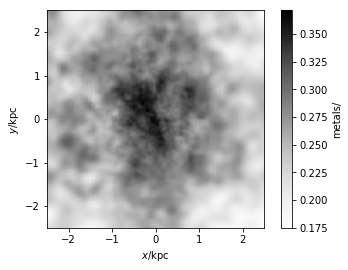

In [16]:
# pynbody.plot.sph.image(subsnap.s, qty="age", av_z=True, units="Gyr", width=width, cmap="Greys", log=False);
pynbody.plot.sph.image(subsnap.s, qty="metals", av_z=True, width=width, cmap="Greys", log=False);
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.star)
L

L: [ 0.03245819  0.5511557  -0.10885588]


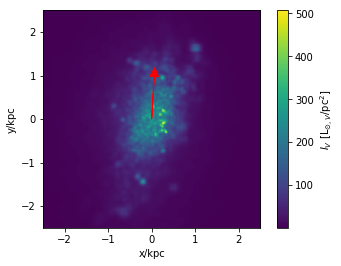

In [17]:
pynbody.analysis.angmom.sideon(subsnap.s)
# subsnap.rotate_y(90)
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, lum_pc2=True)
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
plot_angmom(subsnap.s, ax)

L: [0.08285099 0.5508084  0.0777968 ]
L: [ 3.0987465  2.4194565 -4.0602603]


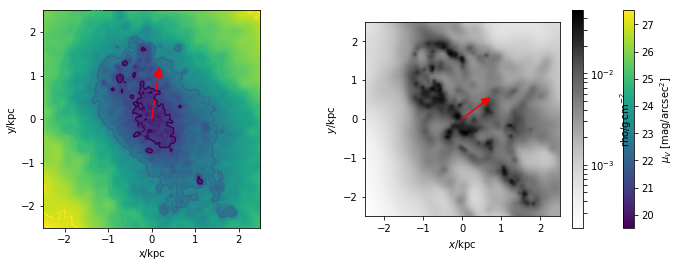

In [65]:
pynbody.analysis.angmom.sideon(subsnap.s)
fig, (ax, ax_g) = plt.subplots(ncols=2, figsize=(12, 4))
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, isophotes=5)
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
plot_angmom(subsnap.s, ax)

pynbody.plot.sph.image(subsnap.g, qty="rho", units="g cm^-2", width=width, cmap="Greys", subplot=ax_g);
L = pynbody.analysis.angmom.ang_mom_vec(subsnap.g)
plot_angmom(subsnap.g, ax_g)

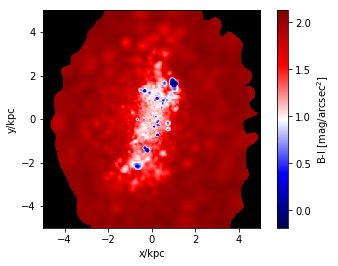

In [19]:
fig, ax = plt.subplots()
sb = color_plot(subsnap.s, width=10, resolution=resolution, subplot=ax, mag_filter=29)
# L = pynbody.analysis.angmom.ang_mom_vec(subsnap.s)
# plot_angmom(subsnap.s, ax)

In [20]:
def minmax_normalization(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

In [21]:
def one_sigma_normalization(arr):
    return (arr - arr.mean()) / arr.std()

3.2995325e-05 0.003036443


(0.0, 1.0)

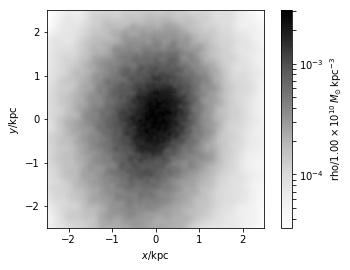

In [22]:
weights = pynbody.plot.sph.image(subsnap.s, qty="rho", av_z=True, width=width, cmap="Greys", log=True);
weights_norm = minmax_normalization((weights).view(np.ndarray))
print(weights.min(), weights.max())
weights_norm.min(), weights_norm.max()

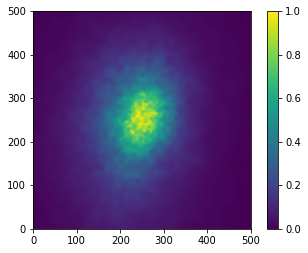

In [23]:
plt.imshow(weights_norm, origin='lower')
plt.colorbar()

In [24]:
np.linspace(sb.min(), sb.max(), 5, dtype=np.int)

/home/michele/Software/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)
/home/michele/Software/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


SimArray([-9223372036854775808, -9223372036854775808,
          -9223372036854775808, -9223372036854775808,
          -9223372036854775808], 'arcsec**-2')

In [25]:
r_eff_kpc3d = pynbody.analysis.luminosity.half_light_r(subsnap, cylindrical=False)
r_eff_kpc3d

SimArray(1.20660696, 'kpc')

In [26]:
r_eff_kpc = pynbody.analysis.luminosity.half_light_r(subsnap, cylindrical=True)
r_eff_kpc

SimArray(0.92174098, 'kpc')

In [27]:
r_eff = kpc2pix(r_eff_kpc, width, resolution)
r_eff

92

/home/michele/Software/miniconda3/lib/python3.6/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


('n: ', 2.2338684872748336, '  other: ', 21.6083005363942)


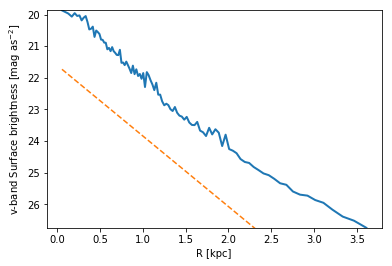

In [28]:
pynbody.plot.sbprofile(subsnap.s, fit_sersic=1.0, rmax=4*r_eff_kpc, diskheight=4*r_eff_kpc )

I think the above fit is wrong. In fact the exp fit is good...

('h: ', 0.5877282095744156, '  u_0:', 20.40658273578456)


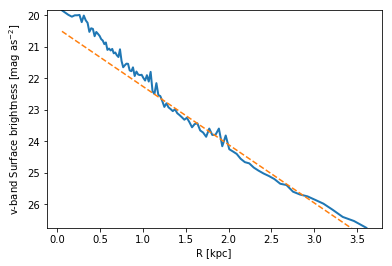

In [29]:
pynbody.plot.sbprofile(subsnap.s, fit_exp=1.0, rmax=4*r_eff_kpc, diskheight=4*r_eff_kpc )

## undoing conversion from pynbody.analisys.profile.sb.
At 10 pc (distance for absolute magnitudes), 1 arcsec is 10 AU=1/2.06e4 pc. In fact:

In [30]:
arcsec = arcsec2_over_pc2_at_10pc = (np.tan(np.pi/180/3600)*10.0)**2
# 1 square arcsecond is thus 2.35e-9 pc^2
arcsec2_over_pc2_at_10pc

2.350443053946619e-09

In [31]:
-2.5*np.log10(arcsec2_over_pc2_at_10pc)

21.572125665865283

Text(0.5,0,'r/kpc')

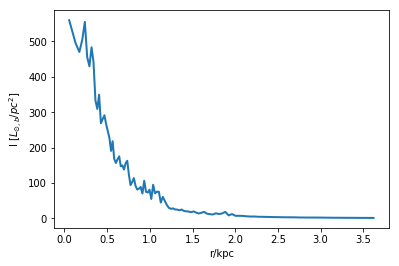

In [32]:
binning='equaln' # contain equal numbers of particles
band='b'
sun_abs_mag = {'u':5.56,'b':5.45,'v':4.8,'r':4.46,'i':4.1,'j':3.66,
               'h':3.32,'k':3.28}[band]
ps = pynbody.analysis.profile.Profile(subsnap.s, type=binning, max=4*r_eff_kpc, bin=100)
r = ps['rbins'].in_units('kpc')
# sbp = 10**(0.4*(sun_abs_mag - 2.5*np.log10(arcsec2_over_pc2_at_10pc) - ps['sb,' + band] ))
sbp = 10**(0.4*(sun_abs_mag + 21.572 - ps['sb,' + band] ))
plt.plot(r, sbp, linewidth=2);
plt.ylabel("I [$L_{{\odot,{}}}/pc^2$]".format(band))
plt.xlabel("r/kpc")

In [33]:
r_eff_kpc3d

SimArray(1.20660696, 'kpc')

# Fit 1D sersic 

In [34]:
s1D_init = models.Sersic1D(r_eff=r_eff_kpc3d, n=2, fixed={'amplitude':False, 'r_eff':False, 'n':False})
# s1d_init = models.ExponentialCutoffPowerLaw1D(alpha=1, x_cutoff=3)
fit_s1D = fitting.SLSQPLSQFitter()
sersic1D = fit_s1D(s1D_init, r, sbp)#, acc=1e-10)
sersic1D

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 51031.97596104353
            Iterations: 43
            Function evaluations: 243
            Gradient evaluations: 43


/home/michele/Software/miniconda3/lib/python3.6/site-packages/pynbody/array.py:463: RuntimeWarning: invalid value encountered in power
  r = np.asarray(np.power(self.view(np.ndarray), numerical_x)).view(SimArray)


<Sersic1D(amplitude=208.7410053, r_eff=0.58592929, n=0.70039186)>

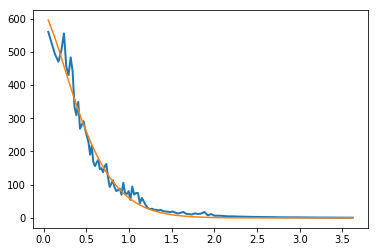

In [35]:
plt.plot(r, sbp, linewidth=2)
plt.plot(r, sersic1D(r))
# plt.plot(r, max(sersic1d(r)) - sersic1d(r))
# plt.ylim(max(sbp), min(sbp))

In [36]:
sersic1D(sersic1D.r_eff), sersic1D.amplitude.value

(208.74100530106995, 208.74100530106995)

# Fit 2D sersic

Redo the plot

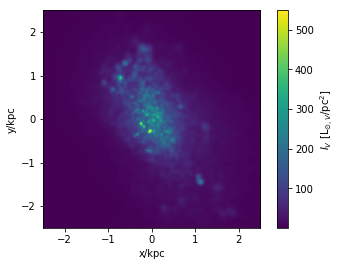

In [38]:
pynbody.analysis.angmom.sideon(subsnap.s)
# subsnap.rotate_y(90)
fig, ax = plt.subplots()
sb = surface_brightness(subsnap.s, width=width, resolution=resolution, subplot=ax, lum_pc2=True, isophotes=5, center=True)

In [39]:
r_eff = kpc2pix(sersic1D.r_eff, width, resolution)
r_eff

58

In [40]:
ellipticity = 0.5
theta = 0*np.pi/180
n = sersic1D.n
r_eff

58

In [51]:
y, x = np.mgrid[:resolution, :resolution]
s_init = models.Sersic2D(r_eff=r_eff, n=n, x_0=resolution/2, y_0=resolution/2, ellip=ellipticity, theta=theta,
                         fixed={'amplitude':False, 'r_eff':True, 'n':False, 'x_0':True, 'y_0':True, 'ellip':False, 'theta':False})#,
#                          bounds={ 'ellip':(0,1)}) #, 'x_0':(200,300) 'y_0':(200,300),
# s_init = models.Polynomial2D(degree=4)
# s_init = models.Gaussian2D(x_mean=resolution/2, y_mean=resolution/2, theta=theta,
#                            fixed={'amplitude':False, 'x_mean':False, 'y_mean':False, 'theta':False}, 
#                            bounds={'theta':(0, np.pi), 'x_mean':(200,300), 'y_mean':(200,300)})

fit_s = fitting.SLSQPLSQFitter()
# notnans = np.isfinite(img)
# sersic = fit_s(s_init, x[notnans], y[notnans], img[notnans])
sersic = fit_s(s_init, x, y, sb)#, weights=weights_norm, maxiter=200)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 56505165.60475507
            Iterations: 30
            Function evaluations: 232
            Gradient evaluations: 30


residual: (-98.0002, 355.0108)


<Sersic2D(amplitude=80.50287498, r_eff=58., n=0.77039671, x_0=250., y_0=250., ellip=2.99081785, theta=0.48187031)>

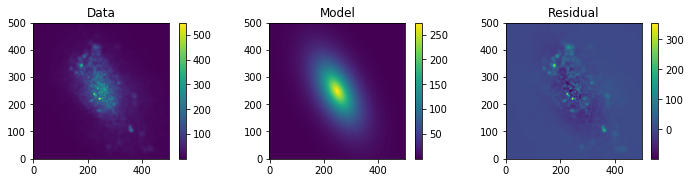

In [52]:
plot_fit(sb, sersic)
sersic

In [47]:
sersic.theta, sersic.ellip

(Parameter('theta', value=0.48187030553566434),
 Parameter('ellip', value=2.990817849241887))

In [42]:
from photutils import isophote
from photutils import EllipticalAperture
from photutils.isophote import EllipseGeometry, Ellipse

In [54]:
 1/sersic.ellip.value

0.33435670455607325

In [48]:
EllipticalAperture?

Init signature: EllipticalAperture(positions, a, b, theta=0.0)
Docstring:     
Elliptical aperture(s), defined in pixel coordinates.

Parameters
----------
positions : array_like or `~astropy.units.Quantity`
    Pixel coordinates of the aperture center(s) in one of the
    following formats:

        * single ``(x, y)`` tuple
        * list of ``(x, y)`` tuples
        * ``Nx2`` or ``2xN`` `~numpy.ndarray`
        * ``Nx2`` or ``2xN`` `~astropy.units.Quantity` in pixel units

    Note that a ``2x2`` `~numpy.ndarray` or
    `~astropy.units.Quantity` is interpreted as ``Nx2``, i.e. two
    rows of (x, y) coordinates.

a : float
    The semimajor axis.

b : float
    The semiminor axis.

theta : float, optional
    The rotation angle in radians of the semimajor axis from the
    positive ``x`` axis.  The rotation angle increases
    counterclockwise.  The default is 0.

Raises
------
ValueError : `ValueError`
    If either axis (``a`` or ``b``) is negative.
File:           ~/Software/mini

Changing theta value
0.33435670455607325 58.0 38.60731113574775


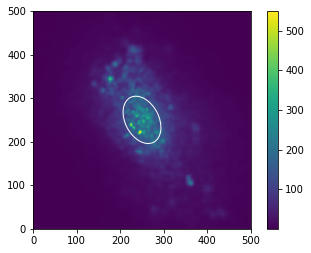

In [62]:
if sersic.ellip.value <= 1:
    ellip = sersic.ellip.value
    theta = sersic.theta.value
else:
    print("Changing theta value")
    ellip = 1/sersic.ellip.value
    theta = np.pi/2 + sersic.theta.value

geometry = EllipseGeometry(x0=resolution/2, y0=resolution/2, sma=sersic.r_eff.value,
                           eps=ellip, pa=theta)
print(geometry.eps, geometry.sma, geometry.sma*(1 - geometry.eps))
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                           geometry.sma*(1 - geometry.eps),
                           geometry.pa)
plt.imshow(sb, origin='lower')
aper.plot(color='white')
plt.colorbar()

In [44]:
from photutils.isophote import Ellipse
ellipse = Ellipse(sb, geometry)

In [ ]:
isolist = ellipse.fit_image()
isolist

In [ ]:
from photutils.isophote import build_ellipse_model
model_image = build_ellipse_model(sb.shape, isolist)
residual = data - model_image

In [ ]:
a_delta = 20
radii = np.arange(30, 200, a_delta)

In [ ]:
compute_stellar_specific_angmom(subsnap)

In [ ]:
half_light_radius = pynbody.analysis.luminosity.half_light_r(s, cylindrical=False)
half_light_radius

In [ ]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5)

def k(r, w, v):
    subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-r))]
    print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.sideon(subsnap.s)
    print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
#     fig, ((ax1, ax2, ax3), (cb1, cb2, cb3)) = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
    fig, ((ax1, ax2, ax3)) = plt.subplots(ncols=3, figsize=(12, 6))
    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, log=False,
                           vmin=-v, vmax=v, show_cbar=False, subplot=ax1)
    
#     fig, ax2 = plt.subplots()#surface_brightness(s, width=width, resolution=resolution);
    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, log=False,
                           show_cbar=False, subplot=ax2)

#     cbar2 = cb2.figure.colorbar(sigma);
#     cbar2.set_label('{} [{}]'.format("$\sigma", subsnap.s['v_disp'].units));

    flux = surface_brightness(subsnap, width=w, resolution=resolution, subplot=ax3, show_cbar=False);
#     cmap = plt.get_cmap(cmap_name)
#     cmap.set_bad('black')
#     cbar3 = cb3.figure.colorbar(flux);
#     cbar3.set_label('{} [mag/arcsec$^2$]'.format(band.upper()));
    
    fig.subplots_adjust(wspace=0.3)
    
w = ipywidgets.interactive(k, r=radius_slider, w=width_slider, v=vel_slider)
w

In [ ]:
max_r = 10 * half_light_radius
radius_slider = ipywidgets.IntSlider(min=0, max=max_r, value=5)
width_slider = ipywidgets.IntSlider(min=0, max=max_r, value=width)
vel_slider = ipywidgets.IntSlider(min=0, max=100, value=10, step=5)

def k(r, w, v):
    subsnap = s[pynbody.filt.Cuboid('{} kpc'.format(-r))]
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    pynbody.analysis.angmom.sideon(subsnap.s)
#     print(pynbody.analysis.angmom.ang_mom_vec(subsnap.s))
    figsize=None#(6,6)
    fig1, ax1 = plt.subplots(figsize=figsize)
    vlos = pynbody.plot.sph.image(subsnap.s, qty='vz', av_z=True, width=w, resolution=resolution, log=False,
                           vmin=-v, vmax=v, show_cbar=True, subplot=ax1)
    
    fig2, ax2 = plt.subplots(figsize=figsize)
    sigma = pynbody.plot.sph.image(subsnap.s, qty='v_disp', av_z=True, width=w, resolution=resolution, log=False,
                           show_cbar=True, subplot=ax2)

#     cbar2 = cb2.figure.colorbar(sigma);
#     cbar2.set_label('{} [{}]'.format("$\sigma", subsnap.s['v_disp'].units));
    fig3, ax3 = plt.subplots(figsize=figsize)
    flux = surface_brightness(subsnap, width=w, resolution=resolution, subplot=ax3, show_cbar=True);
#     cmap = plt.get_cmap(cmap_name)
#     cmap.set_bad('black')
#     cbar3 = cb3.figure.colorbar(flux);
#     cbar3.set_label('{} [mag/arcsec$^2$]'.format(band.upper()));    
w = ipywidgets.interactive(k, r=radius_slider, w=width_slider, v=vel_slider, show_cbar=False)
w